In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.AutoEncoder import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = torch.cat([x, bin_channel], dim=1)
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 4, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = AutoEncoder(4, 3, filters=[16,32,64], kernel_size=7,
                    batch_norm=False, weight_norm=False)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(16, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
  )
)

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [13]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [14]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [15]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [16]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 2655156.46875
	Train Total MSE = 335.5201198032924
	Train Ux MSE = 318.28421892438615
	Train Uy MSE = 4.999368690309071
	Train p MSE = 12.236531734466553
	Validation Loss = 935862.9194335938
	Validation Total MSE = 288.38305389509895
	Validation Ux MSE = 275.88500005068664
	Validation Uy MSE = 4.635198609639204
	Validation p MSE = 7.8628466319047865
Model saved!
Epoch #2
	Train Loss = 1744580.53515625
	Train Total MSE = 238.71129281180245
	Train Ux MSE = 229.41847664969308
	Train Uy MSE = 4.7601497286841985
	Train p MSE = 4.53266826130095
	Validation Loss = 613552.4067382812
	Validation Total MSE = 181.89696262452017
	Validation Ux MSE = 172.30082977189323
	Validation Uy MSE = 4.861426058112544
	Validation p MSE = 4.734712683205786
Model saved!
Epoch #3
	Train Loss = 1191987.84375
	Train Total MSE = 142.09649113246374
	Train Ux MSE = 132.54727136521112
	Train Uy MSE = 4.979250726245699
	Train p MSE = 4.569967803500948
	Validation Loss = 455778.1229248047
	Validat

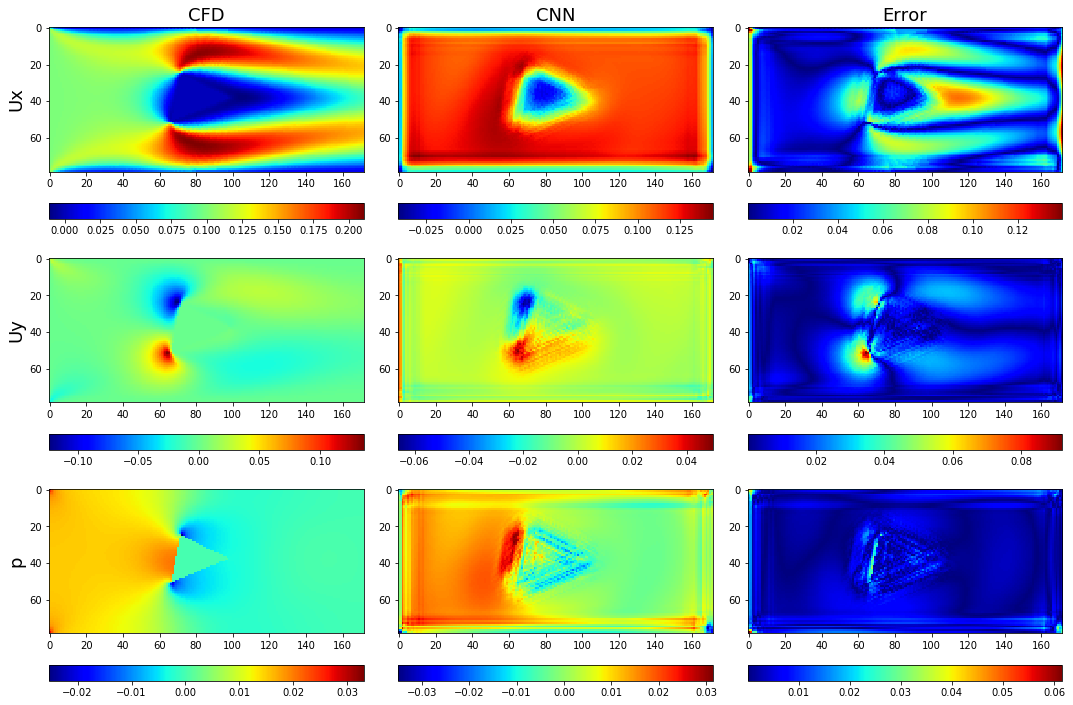

Epoch #11
	Train Loss = 320905.513671875
	Train Total MSE = 32.51020050048828
	Train Ux MSE = 28.857116426740372
	Train Uy MSE = 2.6351736954280307
	Train p MSE = 1.0179096971239363
	Validation Loss = 157623.16247558594
	Validation Total MSE = 32.35616839715766
	Validation Ux MSE = 27.672890145060926
	Validation Uy MSE = 2.5426155539119946
	Validation p MSE = 2.140662609808998
Model saved!
Epoch #12
	Train Loss = 302534.7802734375
	Train Total MSE = 31.264116923014324
	Train Ux MSE = 27.933942249843053
	Train Uy MSE = 2.3539751995177496
	Train p MSE = 0.9761996609824044
	Validation Loss = 150492.9849243164
	Validation Total MSE = 31.270735724162066
	Validation Ux MSE = 26.889394080350144
	Validation Uy MSE = 2.267550768736737
	Validation p MSE = 2.1137908923997184
Model saved!
Epoch #13
	Train Loss = 285999.04296875
	Train Total MSE = 30.1580939519973
	Train Ux MSE = 27.128616151355562
	Train Uy MSE = 2.0691290469396684
	Train p MSE = 0.9603493412335714
	Validation Loss = 144237.492797

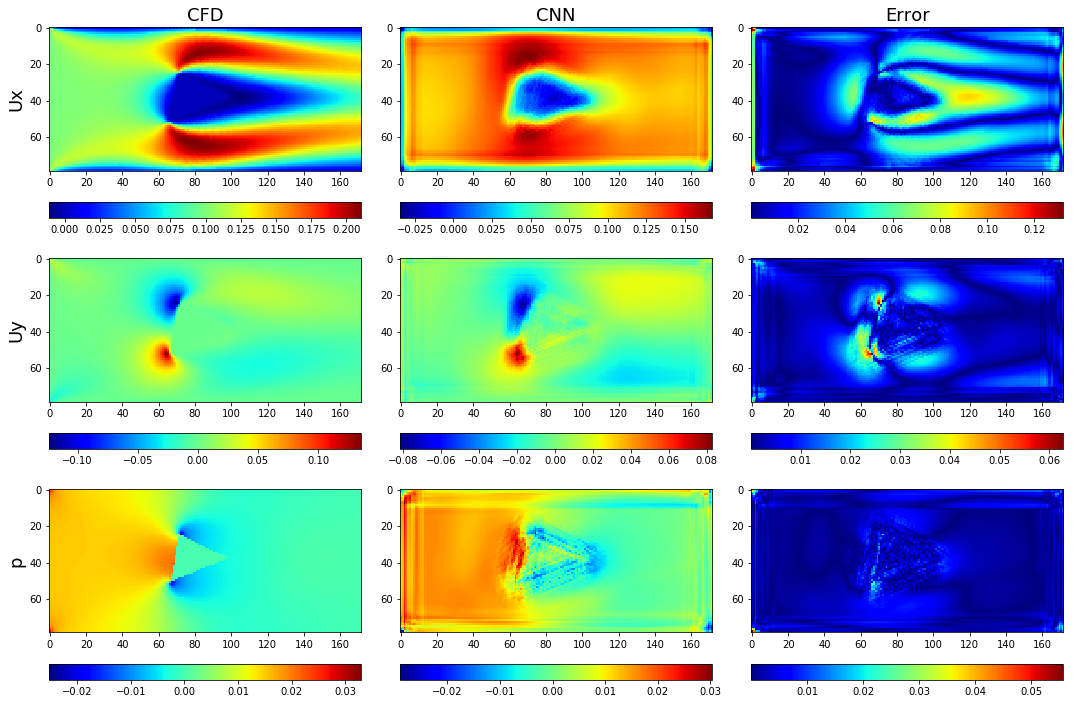

Epoch #21
	Train Loss = 192671.404296875
	Train Total MSE = 20.93574251447405
	Train Ux MSE = 19.080868857247488
	Train Uy MSE = 0.978664375486828
	Train p MSE = 0.8762093363773256
	Validation Loss = 105974.96801757812
	Validation Total MSE = 21.18076954085934
	Validation Ux MSE = 18.12180913773375
	Validation Uy MSE = 1.0531658293054178
	Validation p MSE = 2.005793908424031
Model saved!
Epoch #22
	Train Loss = 185654.6044921875
	Train Total MSE = 19.89578510466076
	Train Ux MSE = 18.06824556986491
	Train Uy MSE = 0.9576518620763507
	Train p MSE = 0.8698876081478029
	Validation Loss = 103924.83972167969
	Validation Total MSE = 20.2368187194877
	Validation Ux MSE = 17.165269274200124
	Validation Uy MSE = 1.0385004533615905
	Validation p MSE = 2.033048258108251
Model saved!
Epoch #23
	Train Loss = 178341.77734375
	Train Total MSE = 18.829780124482653
	Train Ux MSE = 17.032394545418875
	Train Uy MSE = 0.9384563224656242
	Train p MSE = 0.8589294865017846
	Validation Loss = 100083.804428100

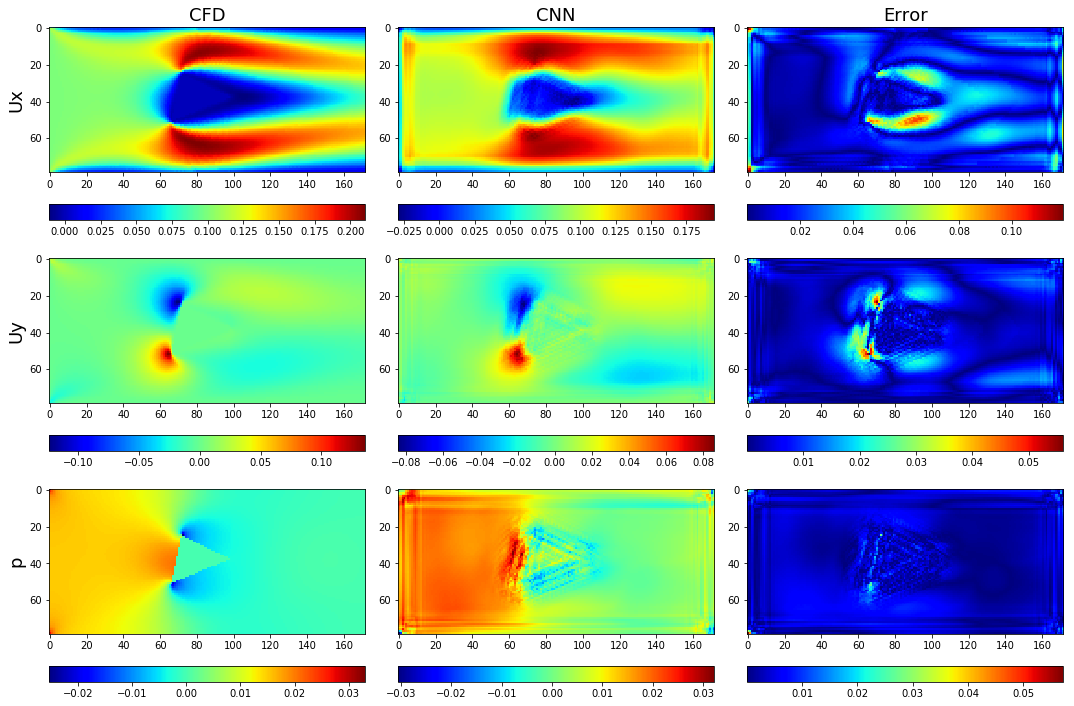

Epoch #31
	Train Loss = 123510.38720703125
	Train Total MSE = 10.526781536283947
	Train Ux MSE = 8.915698392050606
	Train Uy MSE = 0.7904006469817388
	Train p MSE = 0.8206824695780164
	Validation Loss = 77743.44104766846
	Validation Total MSE = 11.256345270414254
	Validation Ux MSE = 8.421525717606594
	Validation Uy MSE = 0.880010384795575
	Validation p MSE = 1.9548089553224999
Model saved!
Epoch #32
	Train Loss = 117996.06127929688
	Train Total MSE = 9.685119038536435
	Train Ux MSE = 8.092027028401693
	Train Uy MSE = 0.7749982334318615
	Train p MSE = 0.8180937972806749
	Validation Loss = 76127.54835510254
	Validation Total MSE = 10.582333323864788
	Validation Ux MSE = 7.748052643244654
	Validation Uy MSE = 0.8635062602152049
	Validation p MSE = 1.9707745290957521
Model saved!
Epoch #33
	Train Loss = 113473.79907226562
	Train Total MSE = 8.982695874713716
	Train Ux MSE = 7.404296761467343
	Train Uy MSE = 0.7562412903422401
	Train p MSE = 0.8221577895539147
	Validation Loss = 73838.4555

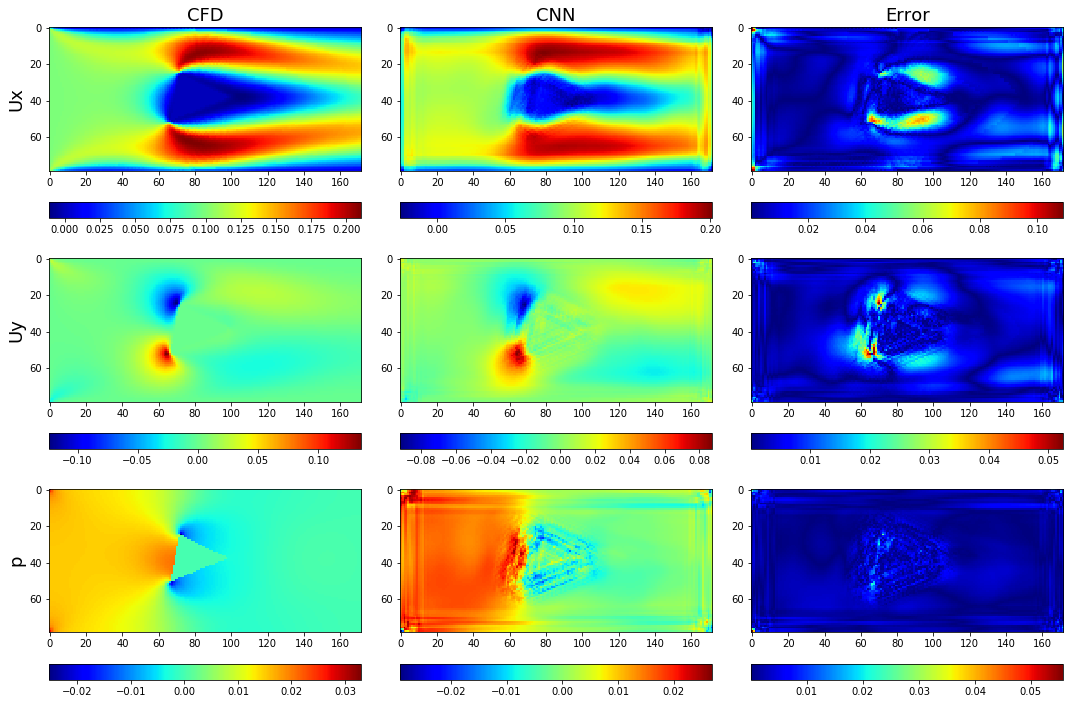

Epoch #41
	Train Loss = 90423.13793945312
	Train Total MSE = 5.932128361293247
	Train Ux MSE = 4.505036978494553
	Train Uy MSE = 0.634146158184324
	Train p MSE = 0.7929451224349794
	Validation Loss = 65805.94342803955
	Validation Total MSE = 7.409989878380587
	Validation Ux MSE = 4.735150876754708
	Validation Uy MSE = 0.7308808028904212
	Validation p MSE = 1.9439580099702294
Model saved!
Epoch #42
	Train Loss = 88624.86767578125
	Train Total MSE = 5.748749891916911
	Train Ux MSE = 4.341738632747105
	Train Uy MSE = 0.6203047093890962
	Train p MSE = 0.7867065377178646
	Validation Loss = 64761.98198699951
	Validation Total MSE = 7.195479647098528
	Validation Ux MSE = 4.550354496417986
	Validation Uy MSE = 0.719111567550052
	Validation p MSE = 1.9260135131362812
Model saved!
Epoch #43
	Train Loss = 87237.19677734375
	Train Total MSE = 5.588413862955003
	Train Ux MSE = 4.193350190208072
	Train Uy MSE = 0.6138694229580107
	Train p MSE = 0.7811943363575709
	Validation Loss = 64309.83248138428

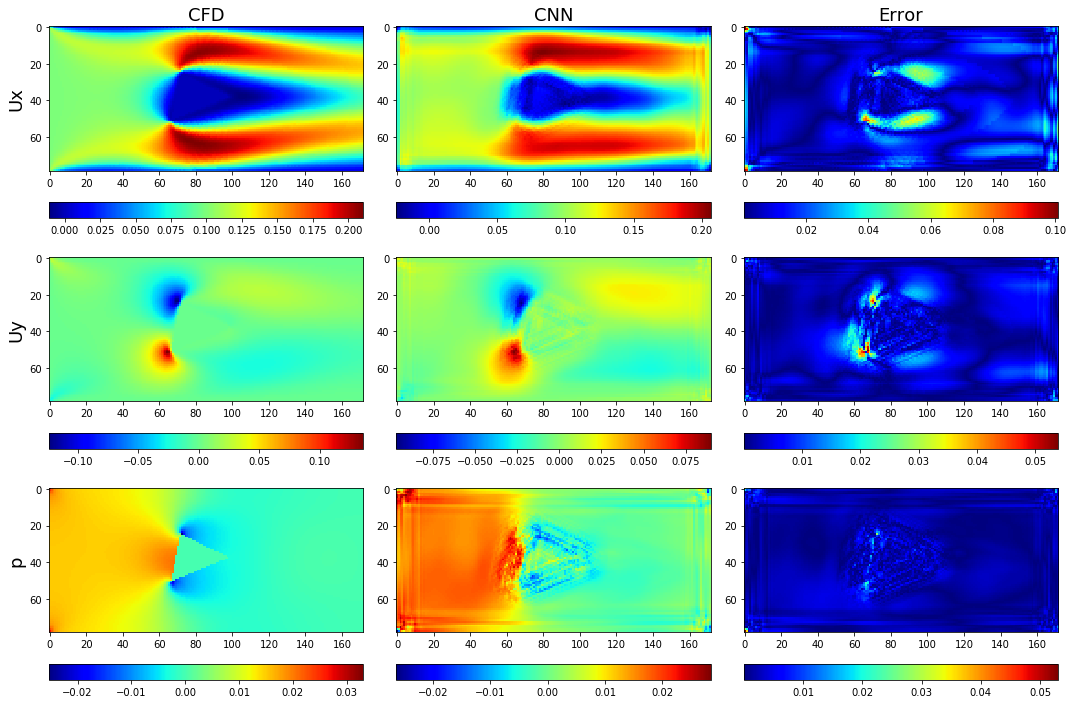

Epoch #51
	Train Loss = 80278.2392578125
	Train Total MSE = 4.8132781982421875
	Train Ux MSE = 3.489873931521461
	Train Uy MSE = 0.5500714849858057
	Train p MSE = 0.7733328069249789
	Validation Loss = 63871.80400085449
	Validation Total MSE = 6.639515210187971
	Validation Ux MSE = 3.98423054969022
	Validation Uy MSE = 0.6549886407324187
	Validation p MSE = 2.0002961230422387
Epoch #52
	Train Loss = 80446.30346679688
	Train Total MSE = 4.775038299106416
	Train Ux MSE = 3.44456908816383
	Train Uy MSE = 0.543013816788083
	Train p MSE = 0.7874554083460853
	Validation Loss = 61129.132011413574
	Validation Total MSE = 6.273631469601166
	Validation Ux MSE = 3.718333496766932
	Validation Uy MSE = 0.6403549631161674
	Validation p MSE = 1.9149429866444694
Model saved!
Epoch #53
	Train Loss = 79376.19738769531
	Train Total MSE = 4.658907538368588
	Train Ux MSE = 3.3380848339625766
	Train Uy MSE = 0.5402589397771018
	Train p MSE = 0.7805637256020591
	Validation Loss = 61242.96437072754
	Validation

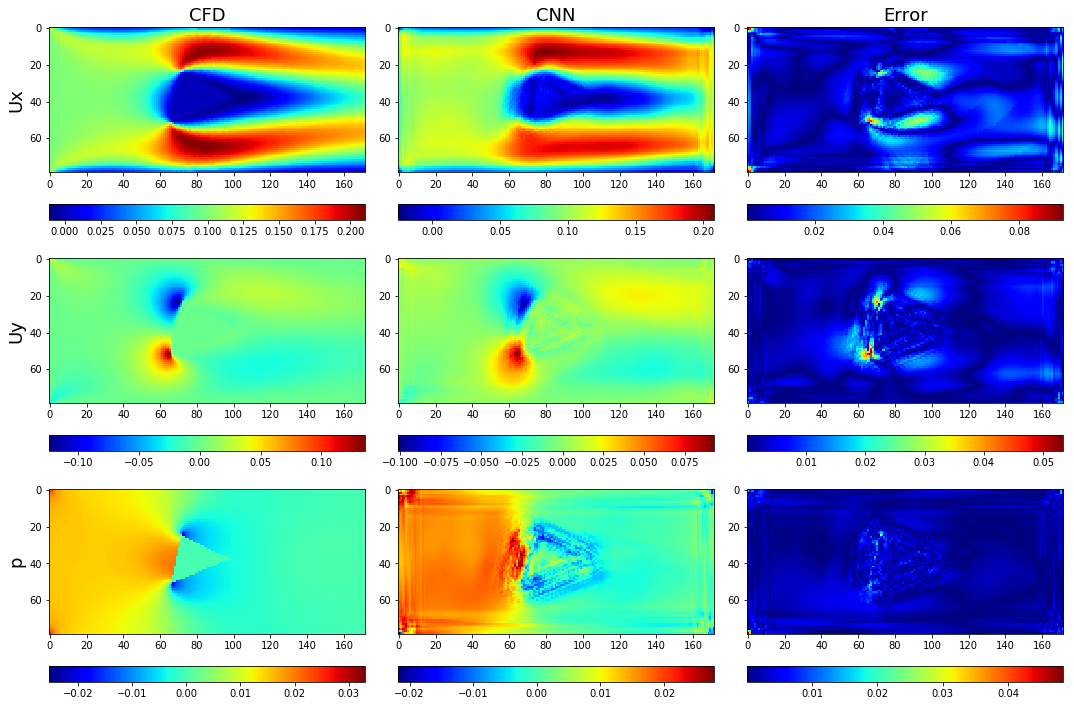

Epoch #61
	Train Loss = 74798.50402832031
	Train Total MSE = 4.262201252437773
	Train Ux MSE = 3.004409744626
	Train Uy MSE = 0.4943548781531198
	Train p MSE = 0.7634366701046625
	Validation Loss = 59252.74814605713
	Validation Total MSE = 5.856564379893372
	Validation Ux MSE = 3.3565395233127897
	Validation Uy MSE = 0.5953078373080719
	Validation p MSE = 1.9047169738471714
Epoch #62
	Train Loss = 75421.40051269531
	Train Total MSE = 4.258285567874
	Train Ux MSE = 2.9868584133329845
	Train Uy MSE = 0.4904193949131739
	Train p MSE = 0.7810078210064343
	Validation Loss = 59581.37823486328
	Validation Total MSE = 5.856727591022901
	Validation Ux MSE = 3.336083257074587
	Validation Uy MSE = 0.6085360916428088
	Validation p MSE = 1.9121082838895411
Epoch #63
	Train Loss = 74399.09216308594
	Train Total MSE = 4.199363345191593
	Train Ux MSE = 2.942830131167457
	Train Uy MSE = 0.4924368602888925
	Train p MSE = 0.7640963530256635
	Validation Loss = 59096.3405456543
	Validation Total MSE = 5.84

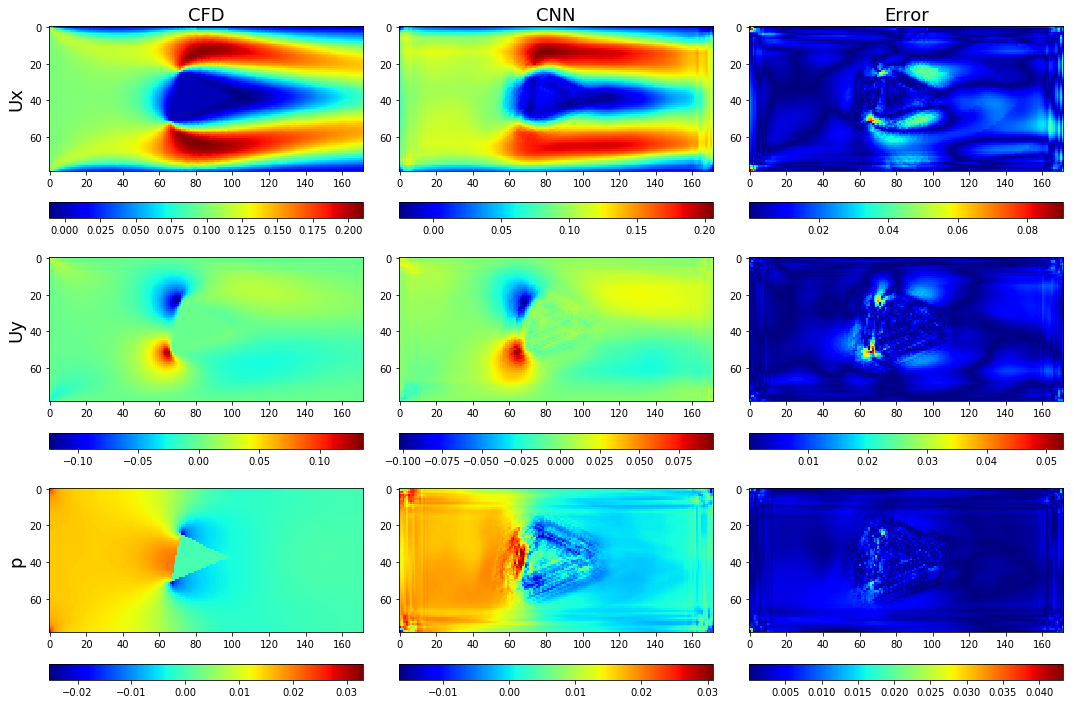

Epoch #71
	Train Loss = 72214.14880371094
	Train Total MSE = 4.0207786446525935
	Train Ux MSE = 2.798549322854905
	Train Uy MSE = 0.4593967795372009
	Train p MSE = 0.7628324553370476
	Validation Loss = 58793.896240234375
	Validation Total MSE = 5.690382280976714
	Validation Ux MSE = 3.20241644968211
	Validation Uy MSE = 0.556512775924379
	Validation p MSE = 1.9314530392315974
Epoch #72
	Train Loss = 71769.38500976562
	Train Total MSE = 3.9976918356759206
	Train Ux MSE = 2.7815920966012135
	Train Uy MSE = 0.4629982042880285
	Train p MSE = 0.7531015390441531
	Validation Loss = 57736.20665740967
	Validation Total MSE = 5.597762084749744
	Validation Ux MSE = 3.1545075446264144
	Validation Uy MSE = 0.5517836642100324
	Validation p MSE = 1.8914706475491343
Model saved!
Epoch #73
	Train Loss = 70994.05383300781
	Train Total MSE = 3.953881093433925
	Train Ux MSE = 2.7514912287394204
	Train Uy MSE = 0.45539683529308866
	Train p MSE = 0.7469929197714442
	Validation Loss = 57957.952671051025
	Val

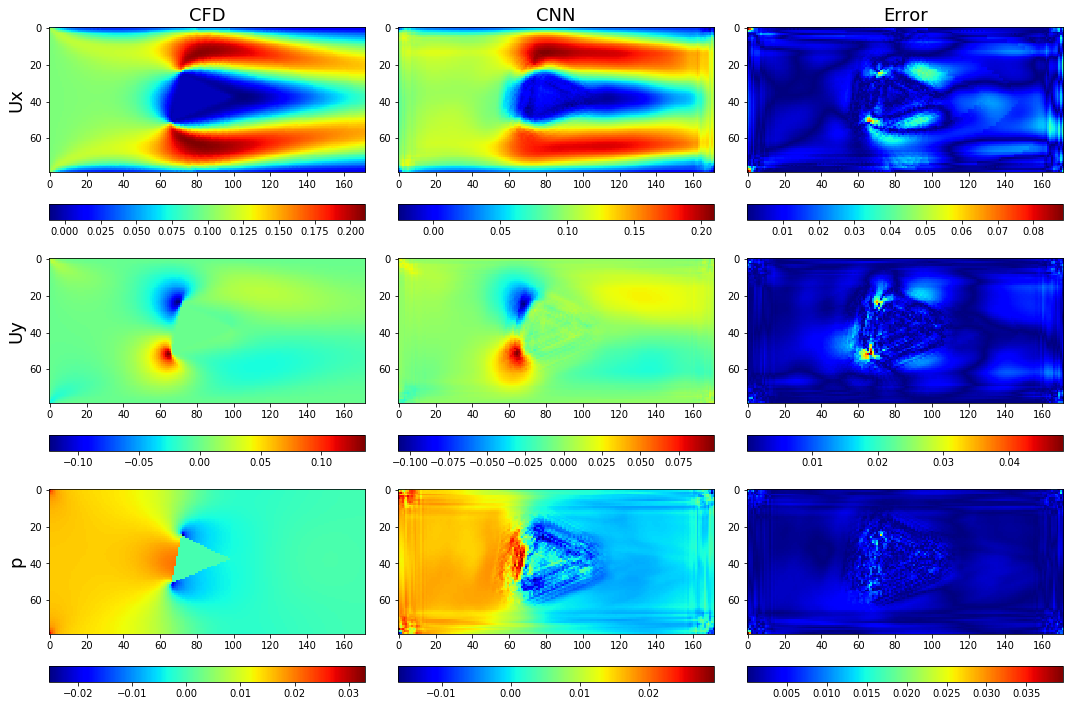

Epoch #81
	Train Loss = 69343.24743652344
	Train Total MSE = 3.8348669438135055
	Train Ux MSE = 2.660125948133923
	Train Uy MSE = 0.4318803832644508
	Train p MSE = 0.7428605634541738
	Validation Loss = 56982.83010482788
	Validation Total MSE = 5.45302707678719
	Validation Ux MSE = 3.0359005144310656
	Validation Uy MSE = 0.5299454302523788
	Validation p MSE = 1.887180965973844
Model saved!
Epoch #82
	Train Loss = 70078.109375
	Train Total MSE = 3.8441922778174993
	Train Ux MSE = 2.6544376271111623
	Train Uy MSE = 0.43026781507900785
	Train p MSE = 0.7594868650748616
	Validation Loss = 57839.00394821167
	Validation Total MSE = 5.593348630984349
	Validation Ux MSE = 3.1490288704736833
	Validation Uy MSE = 0.5321983049485097
	Validation p MSE = 1.912121345427622
Epoch #83
	Train Loss = 69939.59973144531
	Train Total MSE = 3.860511473246983
	Train Ux MSE = 2.674835000719343
	Train Uy MSE = 0.4350663224856059
	Train p MSE = 0.7506101567830358
	Validation Loss = 57060.35326385498
	Validation 

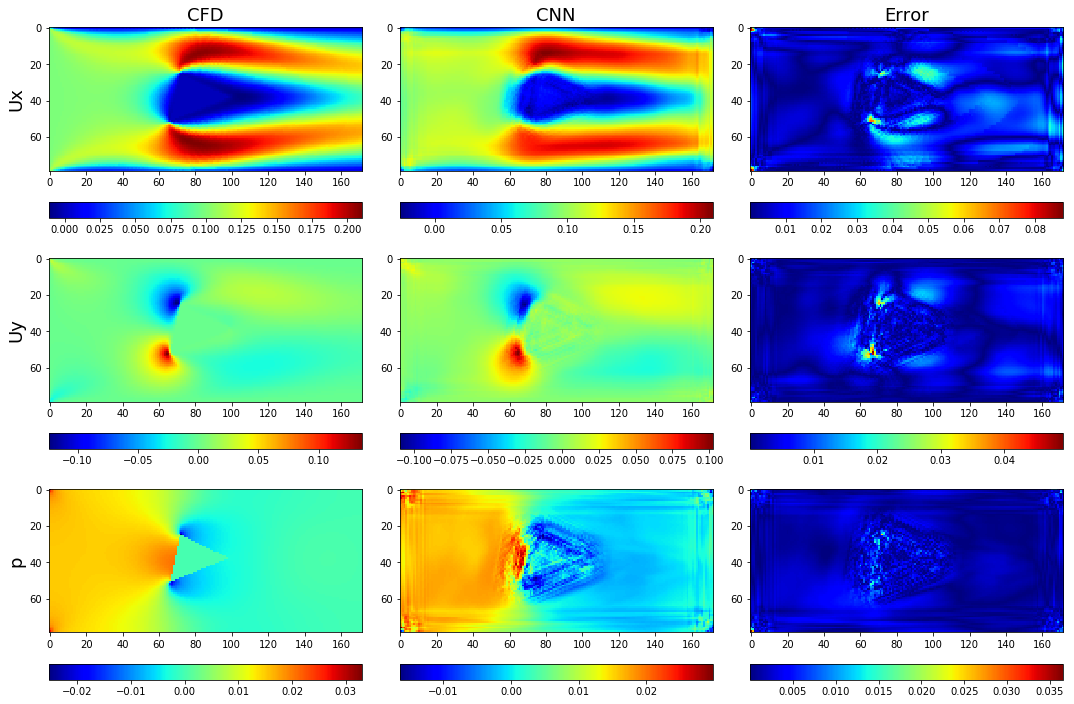

Epoch #91
	Train Loss = 68600.28076171875
	Train Total MSE = 3.7133714925675165
	Train Ux MSE = 2.5415459928058444
	Train Uy MSE = 0.42362017858596074
	Train p MSE = 0.7482054559957414
	Validation Loss = 56895.71048736572
	Validation Total MSE = 5.369206116686231
	Validation Ux MSE = 2.94319908099191
	Validation Uy MSE = 0.5396154770389148
	Validation p MSE = 1.8863915209900137
Epoch #92
	Train Loss = 67632.49267578125
	Train Total MSE = 3.686463197072347
	Train Ux MSE = 2.5350713843391057
	Train Uy MSE = 0.4154679718471709
	Train p MSE = 0.7359238206630662
	Validation Loss = 56765.76443481445
	Validation Total MSE = 5.366489459899057
	Validation Ux MSE = 2.953110895354855
	Validation Uy MSE = 0.5152229948233568
	Validation p MSE = 1.8981556509295963
Epoch #93
	Train Loss = 68257.83325195312
	Train Total MSE = 3.729789995011829
	Train Ux MSE = 2.571150529952276
	Train Uy MSE = 0.41064352080935523
	Train p MSE = 0.7479959545390946
	Validation Loss = 56995.91011810303
	Validation Total M

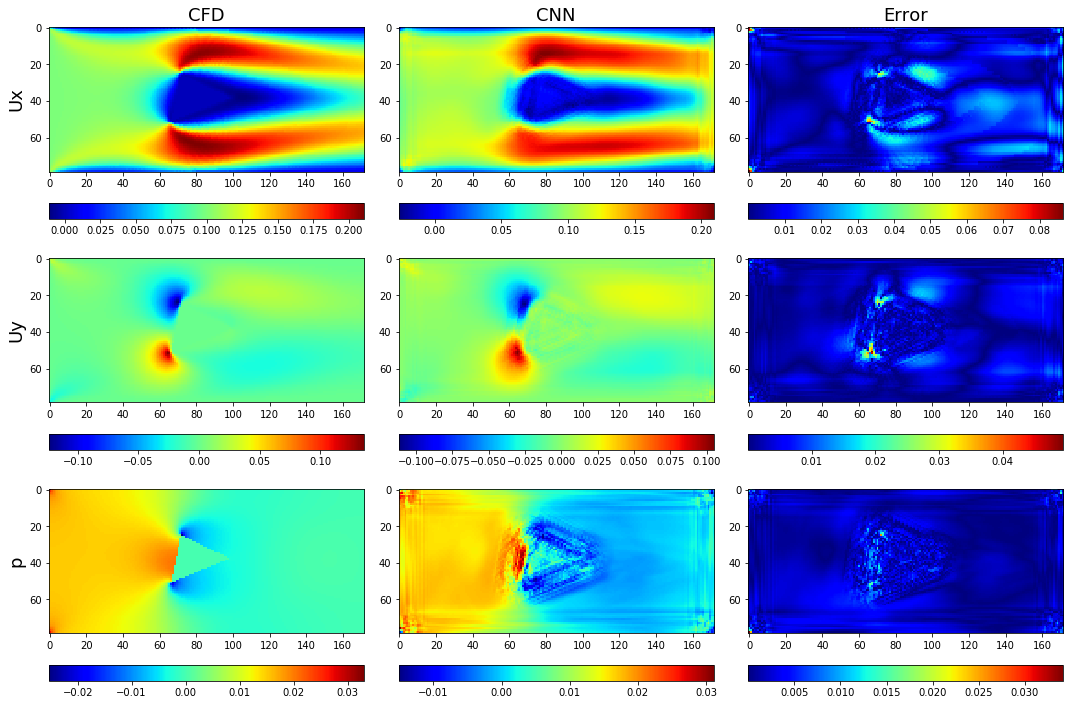

Epoch #101
	Train Loss = 66831.06237792969
	Train Total MSE = 3.615829036349342
	Train Ux MSE = 2.477359953380766
	Train Uy MSE = 0.3993152238073803
	Train p MSE = 0.7391538314876103
	Validation Loss = 56211.483322143555
	Validation Total MSE = 5.276665771708769
	Validation Ux MSE = 2.880130569827598
	Validation Uy MSE = 0.5173213667523077
	Validation p MSE = 1.8792138679732913
Epoch #102
	Train Loss = 66948.56604003906
	Train Total MSE = 3.6112359932490756
	Train Ux MSE = 2.468713953381493
	Train Uy MSE = 0.4024392323834555
	Train p MSE = 0.7400828479301362
	Validation Loss = 56288.67784500122
	Validation Total MSE = 5.268663538368515
	Validation Ux MSE = 2.8678362179792463
	Validation Uy MSE = 0.5140330748162055
	Validation p MSE = 1.8867941740320215
Epoch #103
	Train Loss = 66223.18005371094
	Train Total MSE = 3.599831524349394
	Train Ux MSE = 2.4733445530846003
	Train Uy MSE = 0.3980547856716883
	Train p MSE = 0.728432257260595
	Validation Loss = 56720.16688537598
	Validation Total

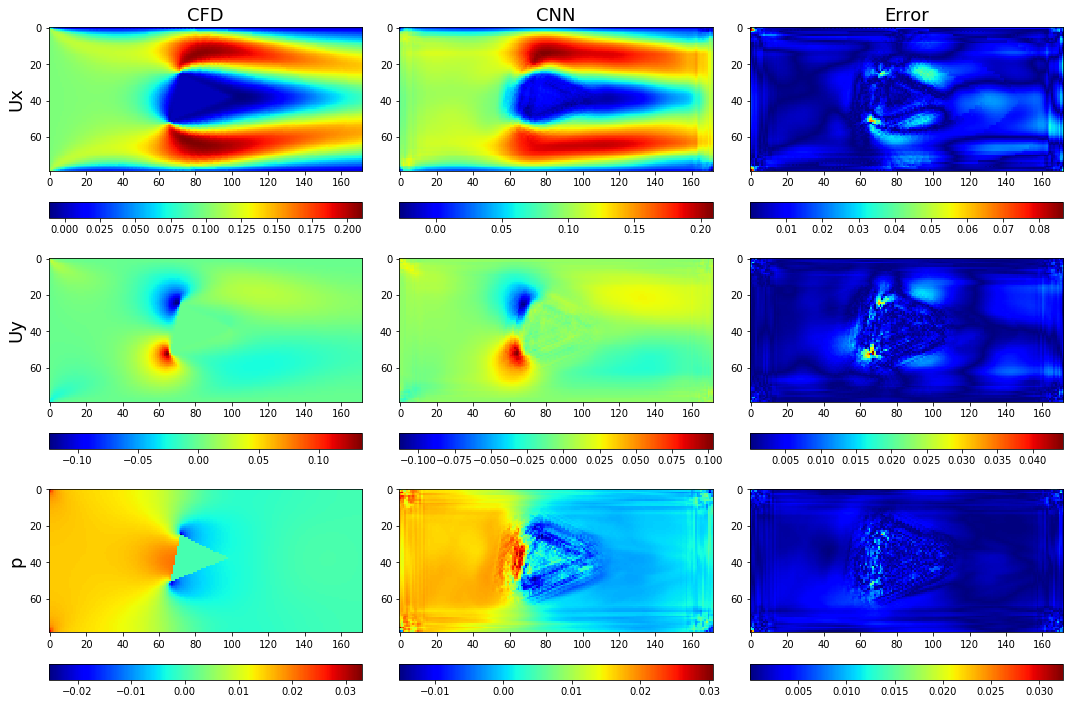

Epoch #111
	Train Loss = 66167.27587890625
	Train Total MSE = 3.5474544366200766
	Train Ux MSE = 2.416719289053054
	Train Uy MSE = 0.39256908141431357
	Train p MSE = 0.7381660104507491
	Validation Loss = 55641.46724700928
	Validation Total MSE = 5.2074315366448
	Validation Ux MSE = 2.8395743172061483
	Validation Uy MSE = 0.48646978915356437
	Validation p MSE = 1.8813873406460953
Model saved!
Epoch #112
	Train Loss = 66015.29211425781
	Train Total MSE = 3.540640359833127
	Train Ux MSE = 2.4127112456730435
	Train Uy MSE = 0.39153600732485455
	Train p MSE = 0.7363930699371156
	Validation Loss = 55627.731216430664
	Validation Total MSE = 5.183693093824552
	Validation Ux MSE = 2.8116315755877115
	Validation Uy MSE = 0.49363048616990085
	Validation p MSE = 1.8784311216672605
Model saved!
Epoch #113
	Train Loss = 65357.4794921875
	Train Total MSE = 3.503213099070958
	Train Ux MSE = 2.3865767206464494
	Train Uy MSE = 0.3863000160171872
	Train p MSE = 0.7303363993054345
	Validation Loss = 56163

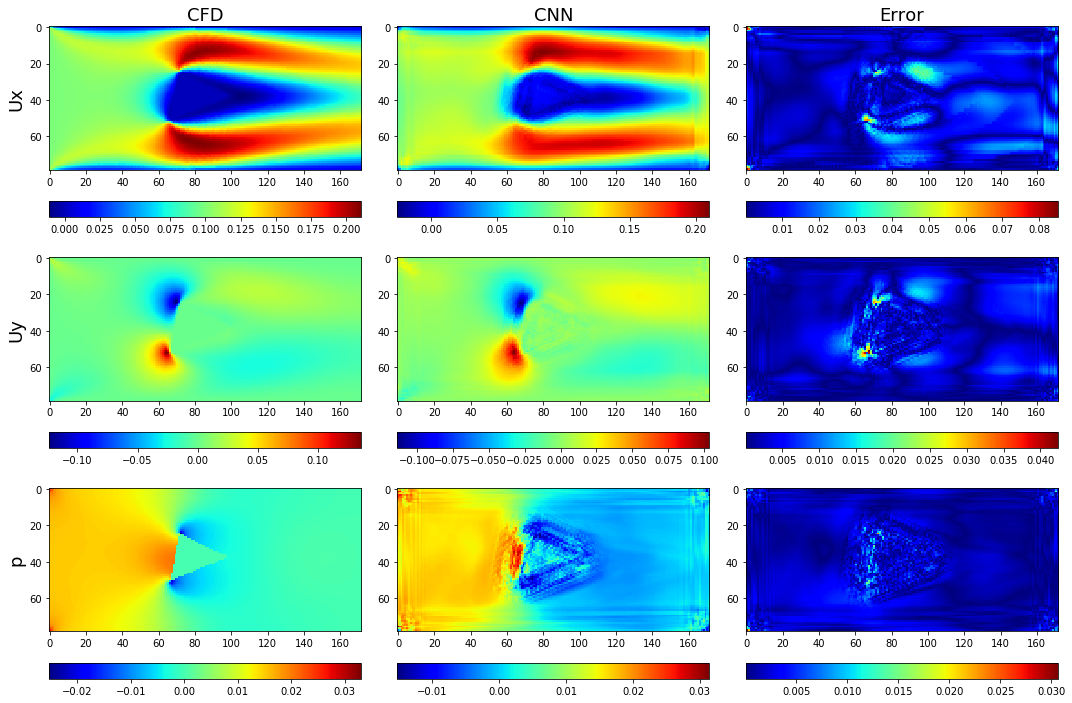

Epoch #121
	Train Loss = 65022.703857421875
	Train Total MSE = 3.47670122555324
	Train Ux MSE = 2.3662349666867937
	Train Uy MSE = 0.3780515789985657
	Train p MSE = 0.7324147799185344
	Validation Loss = 55503.32284927368
	Validation Total MSE = 5.210000415986797
	Validation Ux MSE = 2.84976283159223
	Validation Uy MSE = 0.4864524188338679
	Validation p MSE = 1.8737851990754217
Epoch #122
	Train Loss = 65764.39245605469
	Train Total MSE = 3.528598808106922
	Train Ux MSE = 2.4086908272334506
	Train Uy MSE = 0.3759546350865137
	Train p MSE = 0.7439533713318053
	Validation Loss = 55463.7053604126
	Validation Total MSE = 5.144981580622056
	Validation Ux MSE = 2.779682637085964
	Validation Uy MSE = 0.48084557489540336
	Validation p MSE = 1.8844535034729948
Epoch #123
	Train Loss = 65414.91052246094
	Train Total MSE = 3.5037437563850764
	Train Ux MSE = 2.3879371995017644
	Train Uy MSE = 0.37811330883275895
	Train p MSE = 0.7376933381670997
	Validation Loss = 55388.064109802246
	Validation Tot

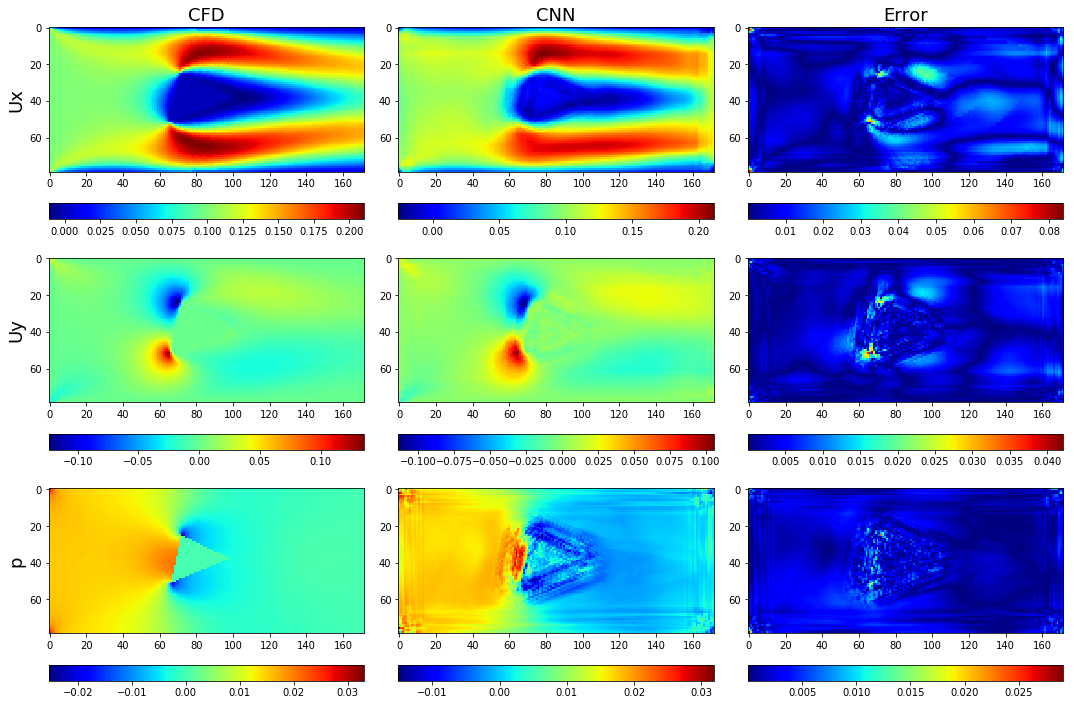

Epoch #131
	Train Loss = 64771.96936035156
	Train Total MSE = 3.4386600028900873
	Train Ux MSE = 2.3300550892239524
	Train Uy MSE = 0.37332672093595776
	Train p MSE = 0.7352782246612367
	Validation Loss = 55228.51912307739
	Validation Total MSE = 5.0747790245861335
	Validation Ux MSE = 2.7119242534505457
	Validation Uy MSE = 0.48363399866543016
	Validation p MSE = 1.8792208477622703
Epoch #132
	Train Loss = 64289.39904785156
	Train Total MSE = 3.4342501844678606
	Train Ux MSE = 2.336486203329904
	Train Uy MSE = 0.371382081082889
	Train p MSE = 0.7263818429339499
	Validation Loss = 54882.72187042236
	Validation Total MSE = 5.056733527398027
	Validation Ux MSE = 2.7129223123966204
	Validation Uy MSE = 0.4709058163694032
	Validation p MSE = 1.8729052658105805
Model saved!
Epoch #133
	Train Loss = 64995.569091796875
	Train Total MSE = 3.4383515971047536
	Train Ux MSE = 2.3257773717244468
	Train Uy MSE = 0.36881156265735626
	Train p MSE = 0.7437626222769419
	Validation Loss = 54725.58520507

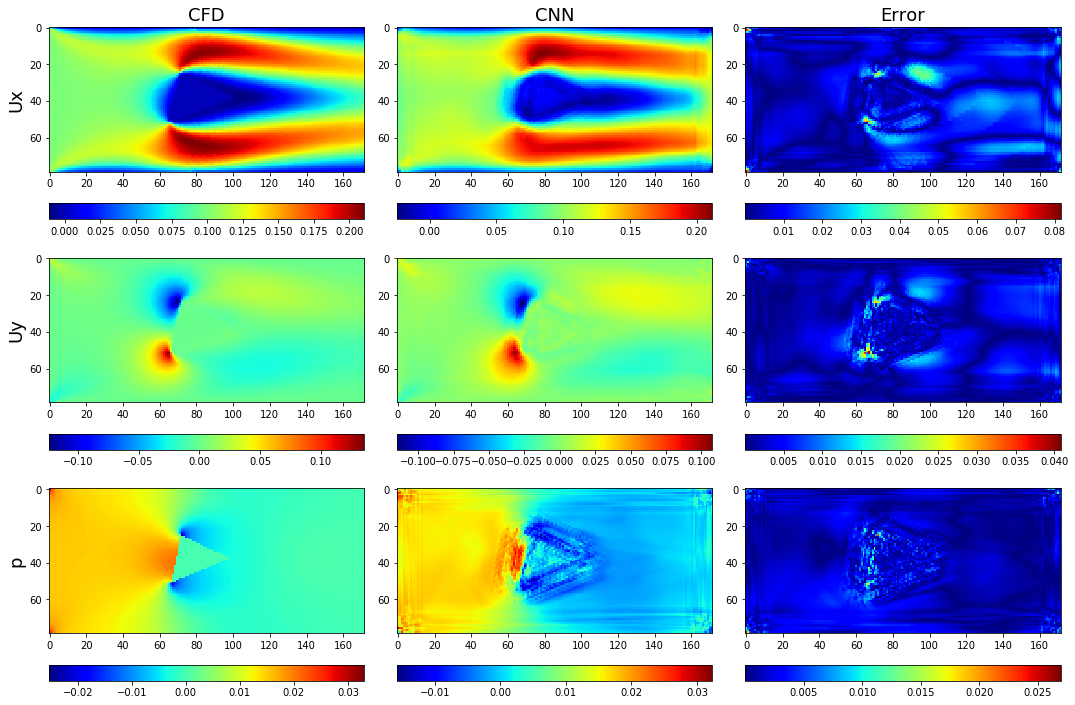

Epoch #141
	Train Loss = 63356.585693359375
	Train Total MSE = 3.3524268695286343
	Train Ux MSE = 2.267732637269156
	Train Uy MSE = 0.36061666693006245
	Train p MSE = 0.7240775408489364
	Validation Loss = 54547.602058410645
	Validation Total MSE = 5.006649246677808
	Validation Ux MSE = 2.6759802280412828
	Validation Uy MSE = 0.4626316281750953
	Validation p MSE = 1.8680373493543339
Model saved!
Epoch #142
	Train Loss = 63145.98547363281
	Train Total MSE = 3.339115682102385
	Train Ux MSE = 2.2572313320069086
	Train Uy MSE = 0.36144501183714184
	Train p MSE = 0.7204392814920062
	Validation Loss = 54682.61013793945
	Validation Total MSE = 5.000871014017547
	Validation Ux MSE = 2.6625571869648863
	Validation Uy MSE = 0.4617275317234977
	Validation p MSE = 1.8765861642608181
Epoch #143
	Train Loss = 63366.09069824219
	Train Total MSE = 3.3517491193044755
	Train Ux MSE = 2.26719792116256
	Train Uy MSE = 0.35883866747220355
	Train p MSE = 0.7257124884497552
	Validation Loss = 54891.5895462036

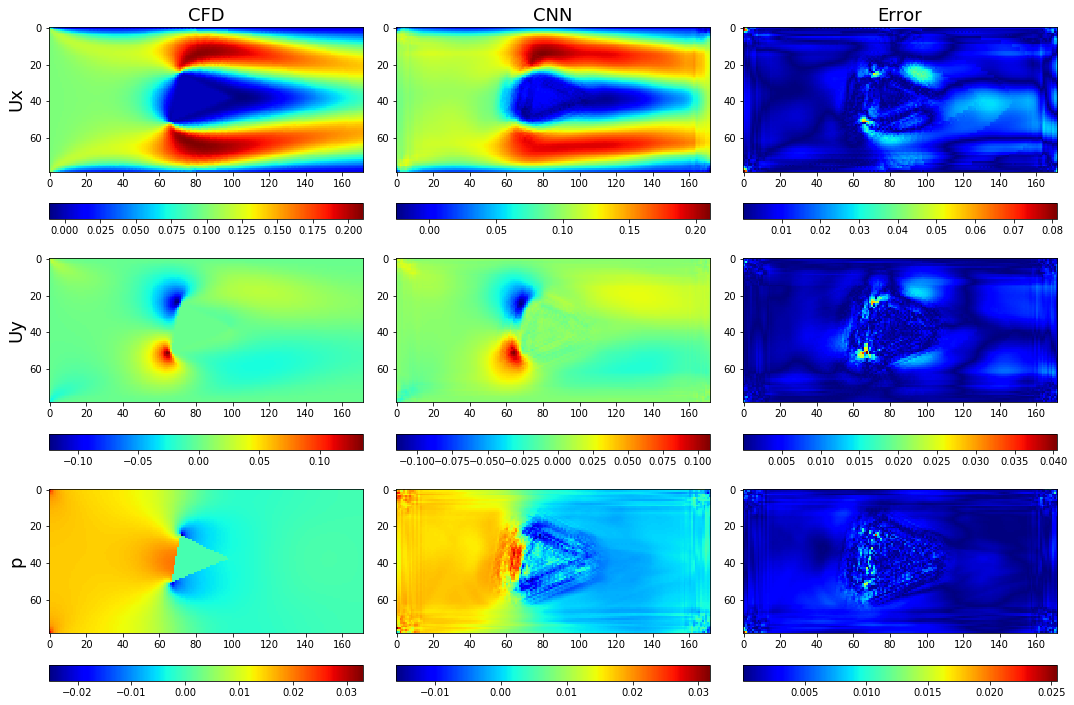

Epoch #151
	Train Loss = 64654.859130859375
	Train Total MSE = 3.3831868228458224
	Train Ux MSE = 2.27059387025379
	Train Uy MSE = 0.3706963438363302
	Train p MSE = 0.7418966023694902
	Validation Loss = 55260.578552246094
	Validation Total MSE = 5.082142178162571
	Validation Ux MSE = 2.720463844319116
	Validation Uy MSE = 0.4761028669284702
	Validation p MSE = 1.8855753773791155
Epoch #152
	Train Loss = 63450.8896484375
	Train Total MSE = 3.3375855003084456
	Train Ux MSE = 2.2496672584896995
	Train Uy MSE = 0.3571756872392836
	Train p MSE = 0.7307424563027564
	Validation Loss = 54467.39466094971
	Validation Total MSE = 4.981113242443045
	Validation Ux MSE = 2.652185930925257
	Validation Uy MSE = 0.4591414895437168
	Validation p MSE = 1.869785772140257
Epoch #153
	Train Loss = 64510.92834472656
	Train Total MSE = 3.4067189693450928
	Train Ux MSE = 2.303685046377636
	Train Uy MSE = 0.3579841007788976
	Train p MSE = 0.7450498835671515
	Validation Loss = 56101.107986450195
	Validation Tota

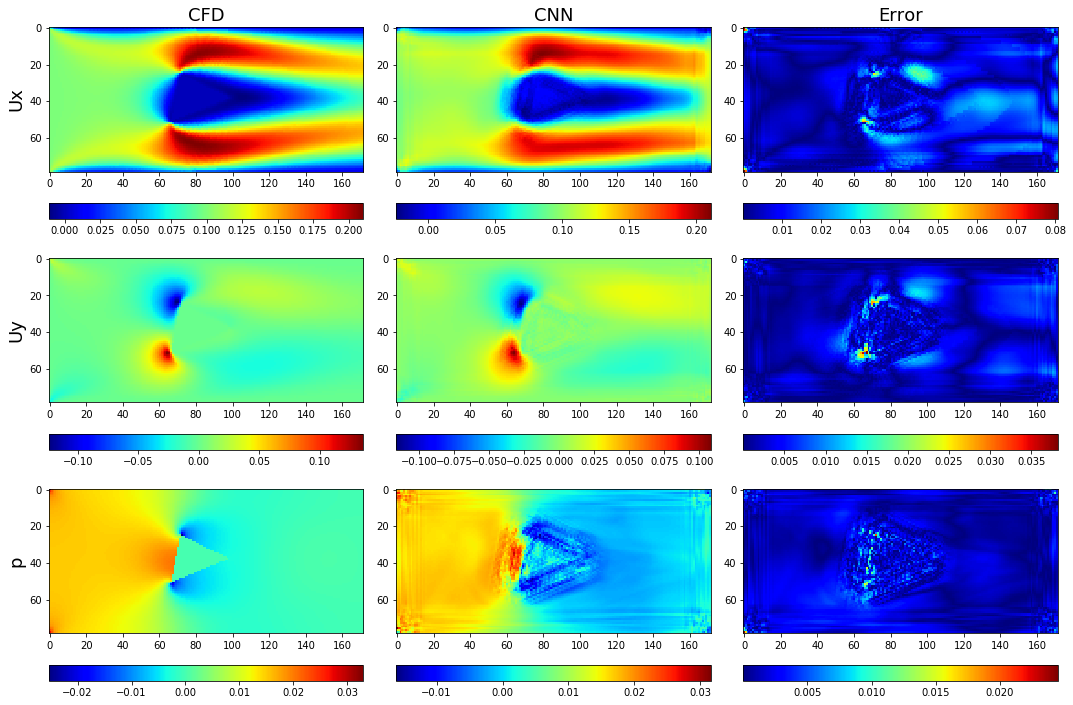

Epoch #161
	Train Loss = 63593.16845703125
	Train Total MSE = 3.3339523814973377
	Train Ux MSE = 2.2433316764377413
	Train Uy MSE = 0.35320811186517986
	Train p MSE = 0.7374126368335315
	Validation Loss = 55734.09191894531
	Validation Total MSE = 5.165944518514983
	Validation Ux MSE = 2.7940809289476864
	Validation Uy MSE = 0.4613083378253924
	Validation p MSE = 1.9105552179178151
Epoch #162
	Train Loss = 62926.172607421875
	Train Total MSE = 3.292025770459856
	Train Ux MSE = 2.209920877502078
	Train Uy MSE = 0.3574757561797187
	Train p MSE = 0.7246291825459117
	Validation Loss = 54146.34467315674
	Validation Total MSE = 4.935857923798083
	Validation Ux MSE = 2.61966207448174
	Validation Uy MSE = 0.45207999734317555
	Validation p MSE = 1.8641159532907512
Model saved!
Epoch #163
	Train Loss = 62312.855529785156
	Train Total MSE = 3.266232422419957
	Train Ux MSE = 2.19682092326028
	Train Uy MSE = 0.34875547956852687
	Train p MSE = 0.720655952890714
	Validation Loss = 54550.48589324951
	V

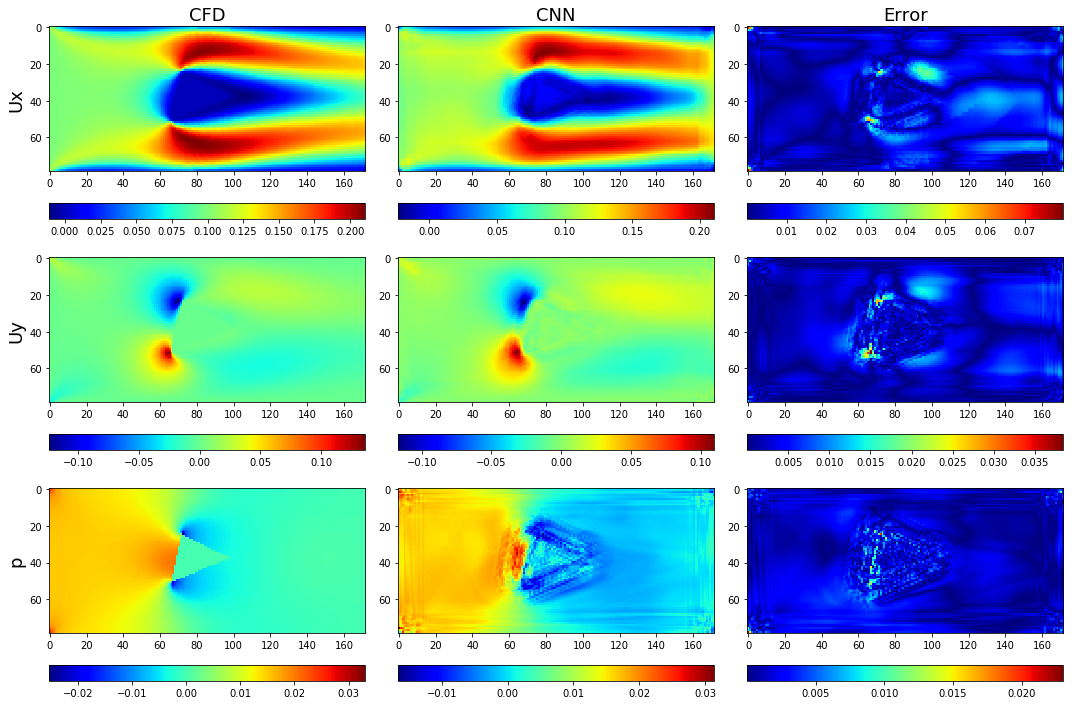

Epoch #171
	Train Loss = 62178.36535644531
	Train Total MSE = 3.254573589279538
	Train Ux MSE = 2.187687572978792
	Train Uy MSE = 0.3447290055808567
	Train p MSE = 0.7221570014953613
	Validation Loss = 54042.08794403076
	Validation Total MSE = 4.929433157699743
	Validation Ux MSE = 2.6190752372609705
	Validation Uy MSE = 0.4473449056742513
	Validation p MSE = 1.86301294323637
Model saved!
Epoch #172
	Train Loss = 62132.844970703125
	Train Total MSE = 3.235909830956232
	Train Ux MSE = 2.1676335505076816
	Train Uy MSE = 0.3445875807887032
	Train p MSE = 0.723688695757162
	Validation Loss = 53999.49313354492
	Validation Total MSE = 4.910426871586836
	Validation Ux MSE = 2.5998534001281106
	Validation Uy MSE = 0.4471748850749851
	Validation p MSE = 1.8633985937054183
Model saved!
Epoch #173
	Train Loss = 62197.42419433594
	Train Total MSE = 3.2261738095964705
	Train Ux MSE = 2.1542810315177556
	Train Uy MSE = 0.3480506801889056
	Train p MSE = 0.7238421425932929
	Validation Loss = 54338.341

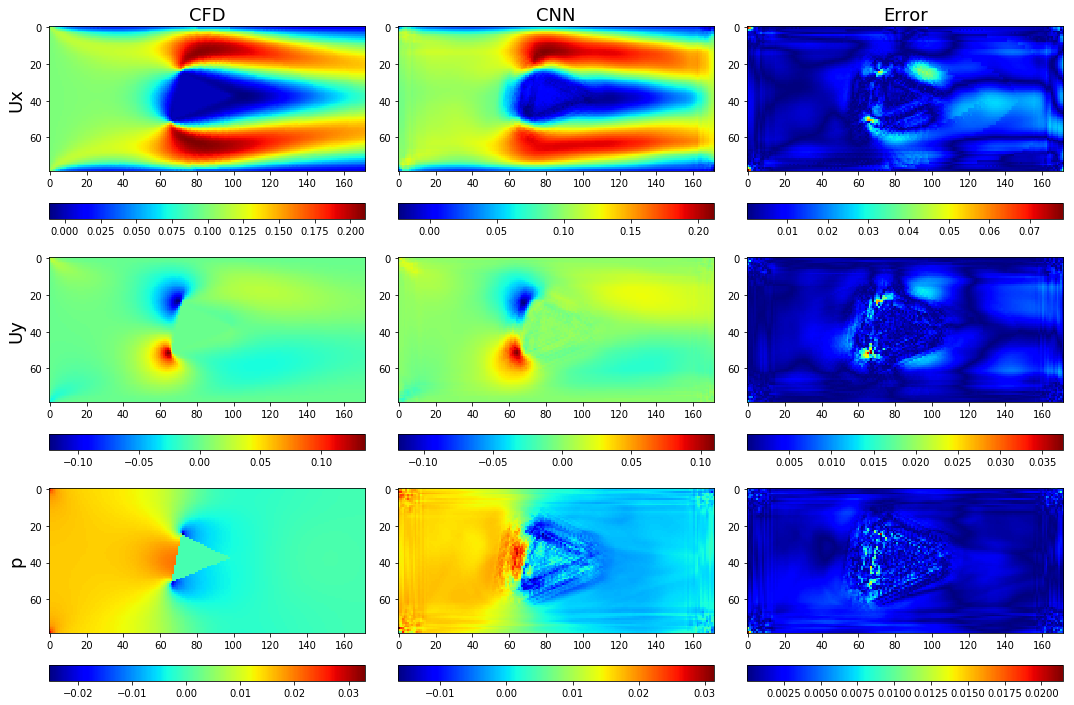

Epoch #181
	Train Loss = 61687.32556152344
	Train Total MSE = 3.215432399795169
	Train Ux MSE = 2.154930665379479
	Train Uy MSE = 0.3430865350223723
	Train p MSE = 0.7174151014714014
	Validation Loss = 53866.850147247314
	Validation Total MSE = 4.8580582818358
	Validation Ux MSE = 2.5484014448410086
	Validation Uy MSE = 0.4439011088292079
	Validation p MSE = 1.8657557414683503
Epoch #182
	Train Loss = 61858.65478515625
	Train Total MSE = 3.192719788778396
	Train Ux MSE = 2.123713340078081
	Train Uy MSE = 0.3495749306111109
	Train p MSE = 0.7194314907704081
	Validation Loss = 56440.890522003174
	Validation Total MSE = 5.058005636538601
	Validation Ux MSE = 2.6300762648400964
	Validation Uy MSE = 0.47967690652217004
	Validation p MSE = 1.948252407376329
Epoch #183
	Train Loss = 64000.434326171875
	Train Total MSE = 3.255419821966262
	Train Ux MSE = 2.1467610597610474
	Train Uy MSE = 0.3471424693153018
	Train p MSE = 0.7615162648615383
	Validation Loss = 54898.193660736084
	Validation Tot

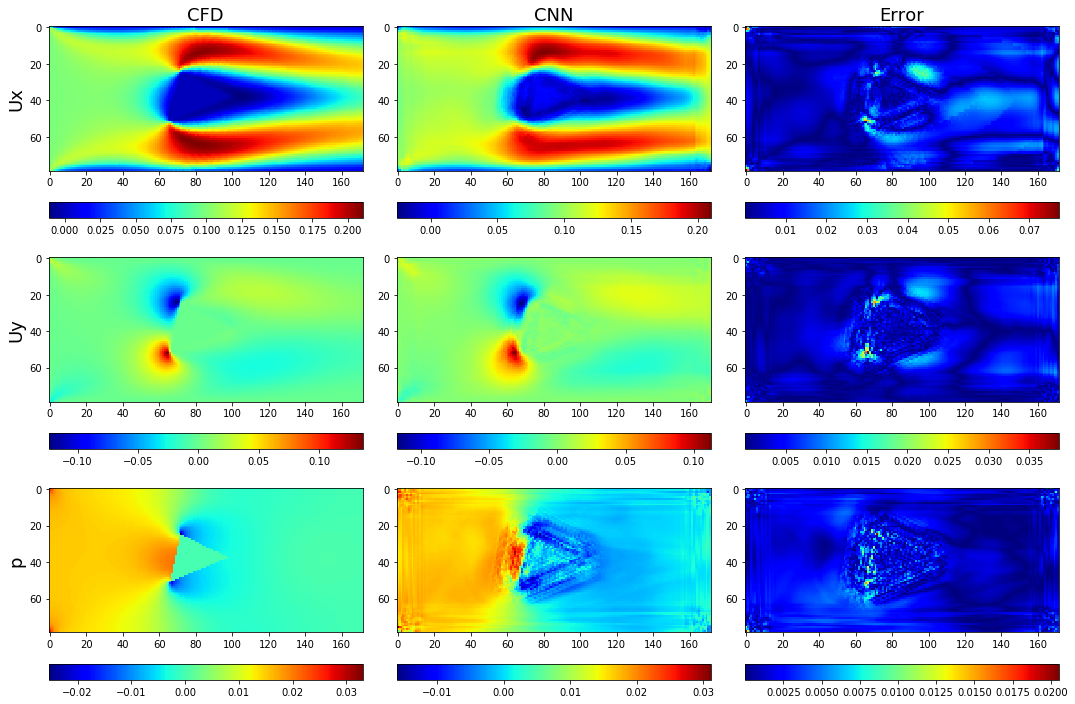

Epoch #191
	Train Loss = 61833.67413330078
	Train Total MSE = 3.180676675978161
	Train Ux MSE = 2.1132709242048717
	Train Uy MSE = 0.33916658801691874
	Train p MSE = 0.7282391676590556
	Validation Loss = 53820.362312316895
	Validation Total MSE = 4.8484002430133755
	Validation Ux MSE = 2.5409292184770313
	Validation Uy MSE = 0.4398946893050184
	Validation p MSE = 1.8675761811667249
Epoch #192
	Train Loss = 61703.87158203125
	Train Total MSE = 3.1791832787649974
	Train Ux MSE = 2.114979409036182
	Train Uy MSE = 0.3373469965798514
	Train p MSE = 0.7268567684860456
	Validation Loss = 53989.3974609375
	Validation Total MSE = 4.911668831914354
	Validation Ux MSE = 2.6036329549901627
	Validation Uy MSE = 0.4398560716825373
	Validation p MSE = 1.8681797301428953
Epoch #193
	Train Loss = 61714.81768798828
	Train Total MSE = 3.202312719254267
	Train Ux MSE = 2.140573847861517
	Train Uy MSE = 0.33866638796670095
	Train p MSE = 0.7230724582359904
	Validation Loss = 54181.63302612305
	Validation T

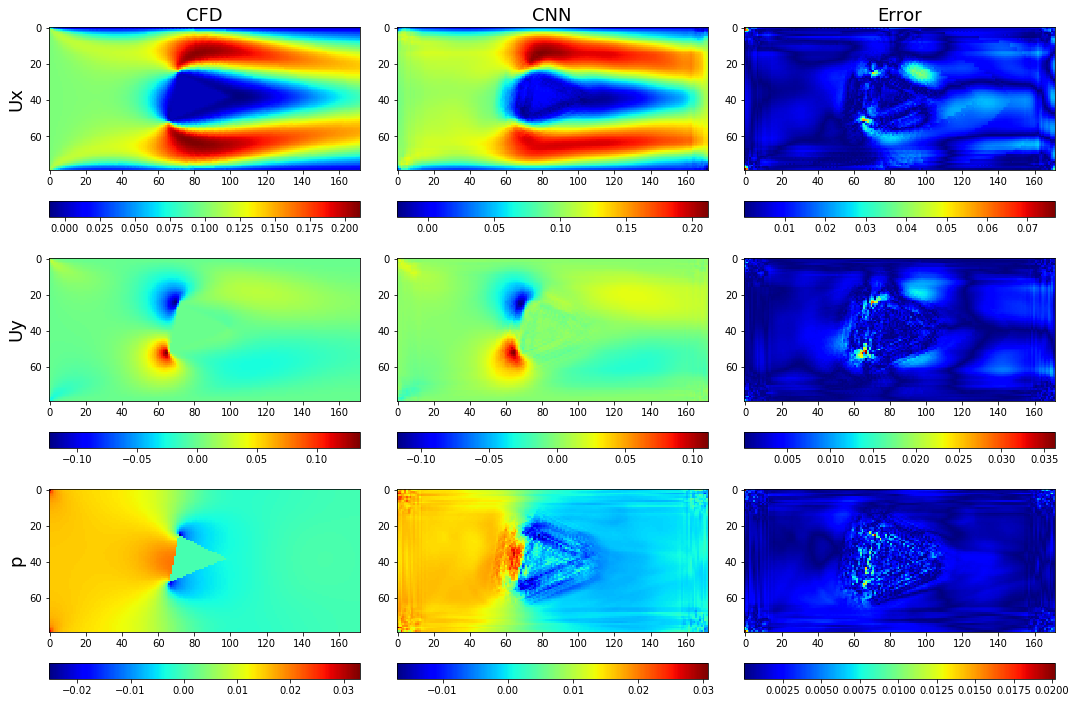

Epoch #201
	Train Loss = 61254.295166015625
	Train Total MSE = 3.1560429334640503
	Train Ux MSE = 2.099030000822885
	Train Uy MSE = 0.3371371513321286
	Train p MSE = 0.7198757007718086
	Validation Loss = 54167.567054748535
	Validation Total MSE = 4.889481437247517
	Validation Ux MSE = 2.5692107487714826
	Validation Uy MSE = 0.43957422699482795
	Validation p MSE = 1.8806966548095938
Epoch #202
	Train Loss = 60913.76330566406
	Train Total MSE = 3.1502273309798468
	Train Ux MSE = 2.101301772253854
	Train Uy MSE = 0.33261447435333613
	Train p MSE = 0.7163111095627149
	Validation Loss = 53562.36056137085
	Validation Total MSE = 4.812492152811334
	Validation Ux MSE = 2.5142016348954304
	Validation Uy MSE = 0.4386346011219553
	Validation p MSE = 1.859655896685115
Model saved!
Epoch #203
	Train Loss = 61342.58056640625
	Train Total MSE = 3.1763338985897245
	Train Ux MSE = 2.120093067487081
	Train Uy MSE = 0.3367373276324499
	Train p MSE = 0.7195034864402953
	Validation Loss = 55185.01802825928

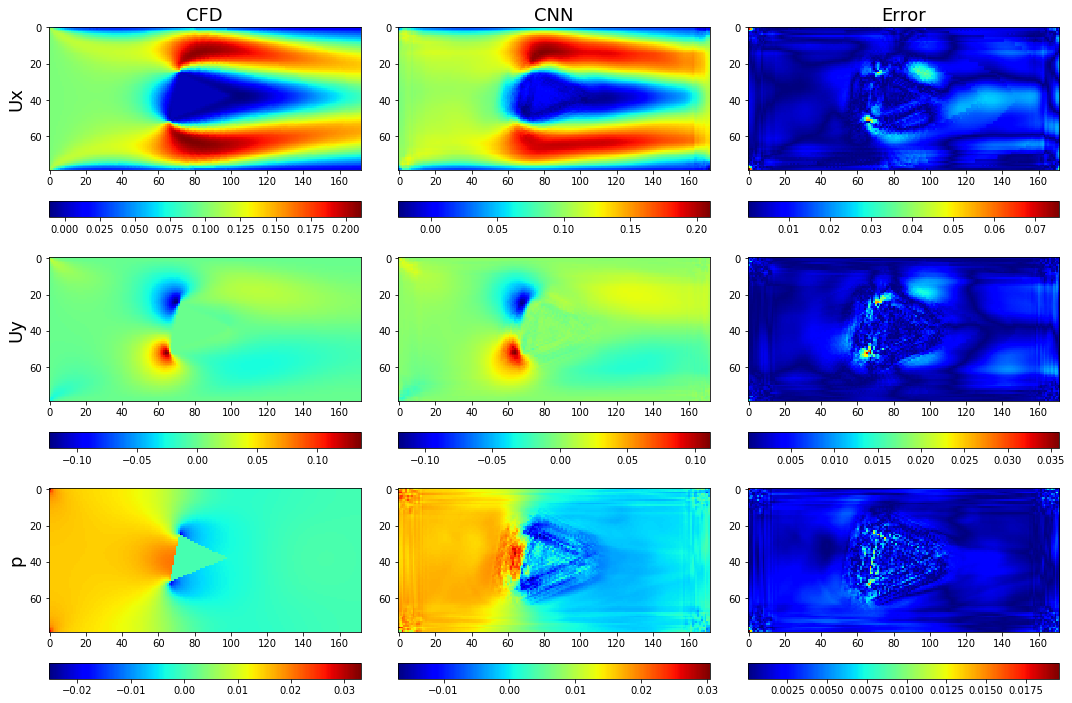

Epoch #211
	Train Loss = 60935.846740722656
	Train Total MSE = 3.1369963884353638
	Train Ux MSE = 2.0856437228974842
	Train Uy MSE = 0.3333489674897421
	Train p MSE = 0.7180036462488628
	Validation Loss = 53480.701805114746
	Validation Total MSE = 4.812886856831481
	Validation Ux MSE = 2.5198249651898976
	Validation Uy MSE = 0.4351579194250404
	Validation p MSE = 1.8579039919257783
Model saved!
Epoch #212
	Train Loss = 60640.25500488281
	Train Total MSE = 3.121050414584932
	Train Ux MSE = 2.0742047230402627
	Train Uy MSE = 0.3337061965749377
	Train p MSE = 0.7131394667639619
	Validation Loss = 53673.55633544922
	Validation Total MSE = 4.838354623028977
	Validation Ux MSE = 2.5384366009062136
	Validation Uy MSE = 0.43535746236985945
	Validation p MSE = 1.8645604478137303
Epoch #213
	Train Loss = 61008.646057128906
	Train Total MSE = 3.1335989236831665
	Train Ux MSE = 2.0810110455467585
	Train Uy MSE = 0.32992849392550333
	Train p MSE = 0.7226594207542283
	Validation Loss = 55748.9963912

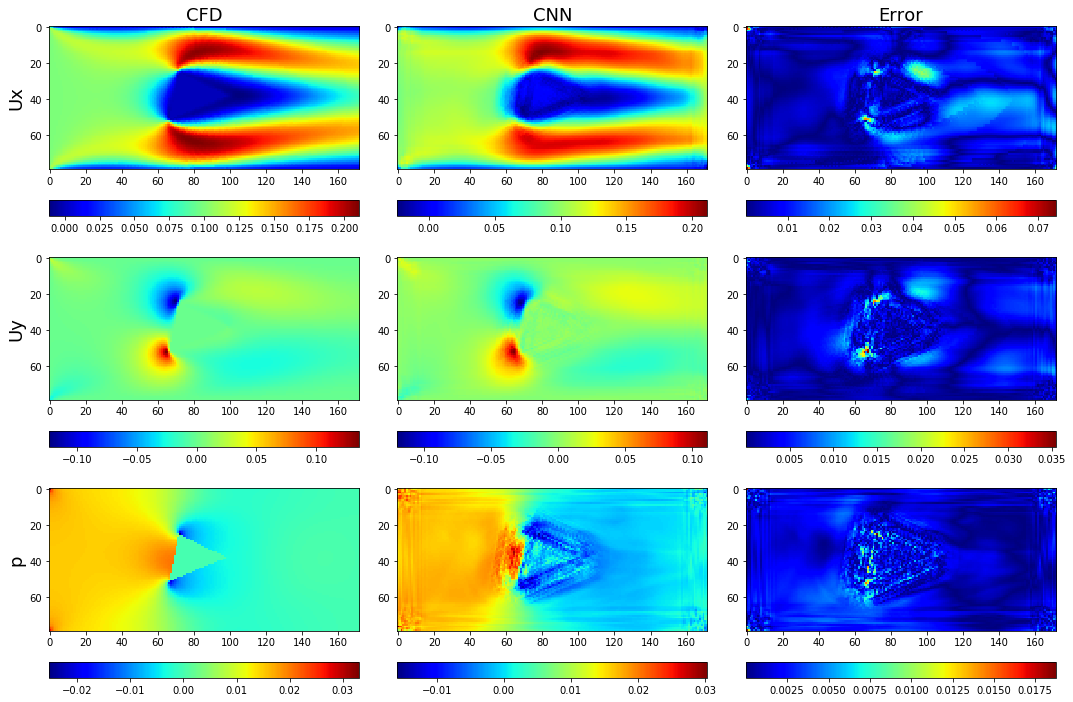

Epoch #221


KeyboardInterrupt: 

In [18]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )